# Контрольная работа

In [52]:
# imports -> выполнить в первую очередь
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sst
import statsmodels.stats.weightstats as ssw
from dataclasses import dataclass
from typing import Optional, Union

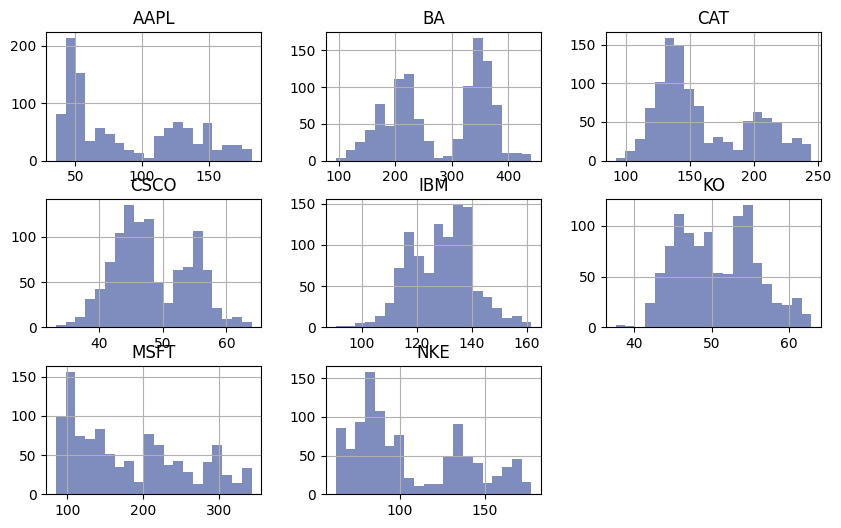

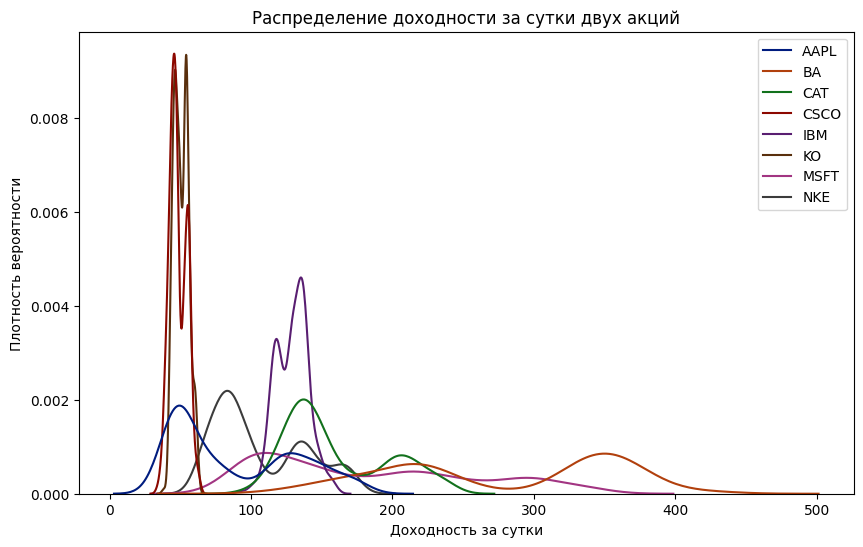

In [53]:
# чтение данных

# укажите где расположен файл с данными
path: str = 'C:\Dev\hw_pankr\cw.csv'

PATH_ERROR_TEXT: str = 'некоррекнто прописан путь к данным'

def read_file(path: str) -> pd.DataFrame:
    """
    Функция считывает данные из файла и
    возвращает дата фрейм
    """
    if os.path.exists(path) and os.path.isfile(path):
        data = pd.read_csv(path, sep=';', index_col ='Date', parse_dates= ['Date'])
        return data
    else:
        raise ValueError(PATH_ERROR_TEXT) and sys.exit()


data =  read_file(path)


data.hist(bins=20, alpha=0.5)
plt.rcParams['figure.figsize'] = [10, 6] 
plt.show();


sns.kdeplot(data=data)
plt.xlabel('Доходность за сутки')
plt.ylabel('Плотность вероятности')
plt.title('Распределение доходности за сутки двух акций')
plt.rcParams['figure.figsize'] = [10, 6]
plt.show();

def validate(column: str) -> bool:
    if column not in data.columns:
       return False
    return True


### задание 1

In [54]:
def find_risk(column: str) -> float:
    """
    функция вычисляет риски для акций
    поменять нужно только второй параметр
    """
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return np.round(data[column].pct_change().dropna().std(), 3)

find_risk('AAPL')

0.021

### задание 2

In [55]:
def calculate_shapiro(column: str) -> float:
    """
    Вычисляет коэффициент Шапиро,
    меняем только название акций
      """
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(sst.shapiro(data[column].pct_change().dropna())[0], 2)


calculate_shapiro('CAT')

0.96

### задание 3

In [56]:
def find_p_value(column: str, income: float) -> float:
    """проверяем гипотезу - выводим п-значение"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(sst.ttest_1samp(data[column].pct_change().dropna(), income)[1], 4)

find_p_value('AAPL', 0.002)

0.4569

### задание 4

In [57]:
class BoxMath:
    """Parents math class for anomalies"""
    CONSTANT: Optional[Union[int, float]] = None

    def __init__(self, df: pd.DataFrame, column: str) -> None:
        """
        инициализация
        """
        self.df = df
        self.column = column
        if self.column  not in set(self.df.columns):
            raise ValueError('ошибка при формировании класса')
        if self.df[self.column].isna().sum() > 0:
            raise ValueError('убери пропуски')

    @property
    def metrics(self) -> dict[str: Union[int, float]]:
        """
        Рассчитываем показатели:
        необходмые для вычислений
        """
        pass

    @property
    def max_not_anomal(self) -> Union[int, float]:
        """
        Вычисляет верхнюю границу усов
        """
        pass

    @property
    def min_not_anomal(self) -> Union[int, float]:
        """
        Вычисляет нижнюю границу усов
        """
        pass

    def is_distribution_normal(self, alpha: float = 0.05)-> bool:
        """определяет нормальное ли распределение"""
        if sst.shapiro(self.df[self.column])[1] < alpha:
            return False 
        return True
    
    @property
    def anomalies(self) -> pd.Series:
        """
        аномальные значения
        """
        return (self.df[
                        (self.df[self.column] < self.min_not_anomal)
                          | 
                        (self.df[self.column] > self.max_not_anomal)
                        ][self.column])
    
    @property
    def anomalies_indexs(self) -> pd.Series:
        """Возращает индексы аномальных строк"""
        return self.anomalies.index


class BoxIQR(BoxMath):
    """
    Класс содержит анализ по выбросам
    """

    CONSTANT: float = 1.5

    @property
    def metrics(self) -> dict[str: Union[int, float]]:
        """
        Рассчитываем показатели:
        -второй квартиль
        -третий квартиль
        -межквартильный размах
        """
        q75, q25 = np.percentile(self.df[self.column], [75 ,25])
        metrics: dict[str: float] = {'iqr': q75 - q25,
                                     'q75': q75,
                                     'q25': q25}
        return metrics
    
    @property
    def max_not_anomal(self) -> Union[int, float]:
        """
        Вычисляет верхнюю границу усов
        """
        max_not_anomal: float = self.metrics['q75'] + self.CONSTANT * self.metrics['iqr']
        if (max_not_anomal > self.df[self.column].max()):
            return self.df[self.column].max()
        else:
            return max_not_anomal

    @property
    def min_not_anomal(self) -> Union[int, float]:
        """
        Вычисляет нижнюю границу усов
        """
        min_not_anomal: float = self.metrics['q25'] - self.CONSTANT * self.metrics['iqr']
        if min_not_anomal < self.df[self.column].min():
            return self.df[self.column].min()
        else:
            return min_not_anomal
    
    @property
    def min_p_anom(self) -> Union[int, float]:
        """минималльный положительный выброс по доходности"""
        return self.anomalies[self.anomalies > 0].min()


class BoxSTD(BoxMath):
    """Считает выбросы в нормальном распределении"""
    CONSTANT: int = 3 

    @property
    def metrics(self)->dict[str:Union[int, float]]:
        """возращает стандартное отклонение и среднее"""
        return {'std': self.df[self.column].std(),
                'mean': self.df[self.column].mean()}
    
    @property
    def max_not_anomal(self) -> Union[int, float]:
        """Возвращает верхнюю границу"""
        max_not_anomal: float = self.metrics['mean'] + self.CONSTANT * self.metrics['std']
        if max_not_anomal > self.df[self.column].max():
            return self.df[self.column].max()
        else:
            return max_not_anomal

    @property
    def min_not_anomal(self) -> Union[int, float]:
        """Возвращает нижнюю границу"""
        min_not_anomal: float = self.metrics['mean'] - self.CONSTANT * self.metrics['std']
        if min_not_anomal < self.df[self.column].min():
            return self.df[self.column].min()
        else:
            return min_not_anomal



class BoxVisualisation:
    """
    Строим графики к выбросам
    """

    def __init__(self, math_object: BoxMath, level: Optional[pd.Series] = None) -> None:
        """инициализация"""
        self.math_object = math_object
        self.level = level

    def represent_box(self, plots_size: tuple[int] = (10, 10)) -> None:
        """выводит бокс-плот"""
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        plt.title('Бокс-плот')
        sns.boxplot(x=self.math_object.df[self.math_object.column], y=self.level)
        plt.show();

    def represent_scatter(self, plots_size: tuple[int] = (15, 15)) -> None:
        """"выводит точечный график"""
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        plt.title('Точечный график')
        sns.scatterplot(x=self.math_object.df.index,
                        y=self.math_object.df[self.math_object.column],
                        hue=self.level)
        plt.axhline(y=self.math_object.max_not_anomal,
                    color='red',
                    linestyle='dotted',
                    label='Максимальное значение без выбросов')
        plt.axhline(y=self.math_object.min_not_anomal,
                    color='red',
                    linestyle='dotted',
                    label='Минимальное значение без выбросов')
        plt.axhline(y=self.math_object.df[self.math_object.column].median(),
                    color='green',
                    linestyle='--',
                    label='Медиана')
        plt.axhline(y=self.math_object.df[self.math_object.column].mean(),
                    color='pink',
                    linestyle='--',
                    label='Среднее значение')
        plt.legend()
        plt.show();

    def represent_in_detail(self, plots_size: tuple[int] = (10, 10)) -> None:
        """приближенный бокс-плот"""
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        plt.title('Приближенный бокс-плот')
        sns.boxplot(
            x=self.math_object.df[self.math_object.column], y=self.level
            ).set_xlim([self.math_object.min_not_anomal,
                        self.math_object.max_not_anomal])
        plt.show();

    def represent_histplot(self, plots_size: tuple = (10, 10)) -> None:
        """распределение с выбросами"""
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        sns.displot(self.math_object.df[self.math_object.column])
        plt.axvline(x=self.math_object.df[self.math_object.column].mean(),
                    color='green',
                    linestyle='--',
                    label='Среднее значение')
        plt.axvline(x=self.math_object.min_not_anomal,
                    color='orange',
                    linestyle=':',
                    label='Минимальное значение без выбросов')
        plt.axvline(x=self.math_object.max_not_anomal,
                    color='orange',
                    linestyle=':',
                    label='Максимальное значение без выбросов')
        plt.legend()
        plt.show();

@dataclass
class PrinterReport:
    """Выводим отчет"""

    math_object: BoxMath
    visual_object: BoxVisualisation
    visualisations = {'boxplot': 'represent_box',
                      'detail_box_plot': 'represent_in_detail',
                      'scatterplot': 'represent_scatter',
                      'histplot': 'represent_histplot'}
    
    def print_result(self, parametrs: Optional[dict[str, tuple[Union[int, float]]]] = None) -> None:
        if not set(parametrs.keys()).issubset(set(self.visualisations.keys())):
            raise ValueError('таких графиков не строим')
        for parametr in parametrs.values():
            if parametr != None:
                if not isinstance(parametr, tuple):
                    raise ValueError('передайте размер кортеджем')
                else:
                    if len(parametr) != 2:
                        raise ValueError('длина должна быть 2')
        for metric, value in self.math_object.metrics.items():
            print(f'{metric} - {value}')
        print('выбросов % - ',
              round((len(self.math_object.anomalies) / len( self.math_object.df)) * 100, 2))
        if parametrs is not None:
            for parametr in parametrs:
                getattr(self.visual_object,
                        self.visualisations[parametr])(parametrs[parametr])


def is_distribution_normal(data: pd.Series, alpha: float = .05) -> bool:
    """определяет нормальное ли распределение"""
    if sst.shapiro(data)[1] < alpha:
        return False 
    return True


def make_full_analyses_anomalies(data: pd.DataFrame,
                                 column: str,
                                 factor: Optional[pd.Series] = None,
                                 parametrs_for_result: dict[str: Optional[tuple]] = {'boxplot': None,
                                                                                     'detail_box_plot': None,
                                                                                     'scatterplot': None,
                                                                                     'histplot': None}) -> None:
    
    if is_distribution_normal(data[column]):
        math: BoxMath = BoxSTD(data, column)
    else:
        math: BoxMath = BoxIQR(data, column)
    visualisation: BoxVisualisation = BoxVisualisation(math, factor)
    report: PrinterReport = PrinterReport(math, visualisation)
    report.print_result(parametrs_for_result)




In [58]:
def find_min_p_anomal(column: str) -> float:
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(BoxIQR(data.pct_change().dropna(), column).min_p_anom, 3)

find_min_p_anomal('KO')


0.025

In [59]:
# Задание 5
# ?

### задание 6

In [60]:
def number_period(column: str, value: int) -> int:
    """
    кол-во периодов, стоимрость больше значения
    меняем только название акции
    """
    return sum(data[column] > value)


number_period('CAT', 170)

348

### задание 7

In [61]:
def mean_income(column: str) -> float:
    """Выводим среднюю доходность"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(data[column].pct_change().dropna().mean(), 5)

mean_income('AAPL')

0.00153

### задание 8

In [62]:
def calc_interval(column: str) -> float:
    """верхяя граница доверительного интервала для средней доходности"""
    if column not in data.columns:
        raise ValueError('нет такой компании, перепроверь!')
    return round(ssw.DescrStatsW(data.pct_change().dropna()[column]).tconfint_mean(alpha=0.95)[1], 5)

calc_interval("AAPL")

0.00157

### задание 9

In [63]:
# ttest о равенстве средней доходности - внимание на даты
group_1 = data.pct_change().dropna().loc['02.03.2020':'31.03.2020']['KO']
group_2 = data.pct_change().dropna().loc['01.03.2021':'31.03.2021']['KO']

round(sst.ttest_ind(group_1, group_2)[0], 2)

-0.96

### задание 10

In [64]:

def find_min_income_day(column: str):
    """наименьшая доходность акциии"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return data[column].pct_change().dropna().idxmin()

find_min_income_day('MSFT')

'16.03.2020'

### задание 11

0.0105
0.0029


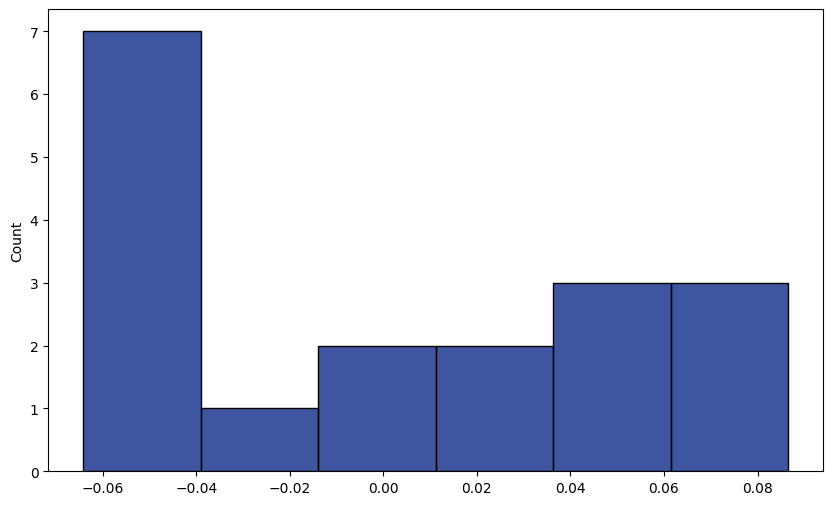

In [65]:
# 11 задание - что-то совсем плохое - точечная оценка средней доходности

# разница средних
print(round(group_2.mean()-group_1.mean(), 4))

# mean difference per day
index_1 = [index[0:5] for index in group_1.index]
index_2 = [index[0:5] for index in group_2.index]
g1 = group_1.to_dict()
g2 = group_2.to_dict()
common_days = list(set(index_1).intersection(set(index_2)))
diff = [g2[day + '.2021'] - g1[day + '.2020'] for day in common_days]
sns.histplot(diff)
print(round(sum(diff)/len(diff), 4))


### 12 задание

In [67]:
def calculate_iqr(column: str) -> float:
    """Находит межквартильный размах"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(BoxIQR(data, column).metrics['iqr'], 2)

calculate_iqr('NKE')

52.95

### 13 задание

In [68]:

def find_max_income_day(column: str):
    """находит дату максимальной доходности"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return data[column].pct_change().dropna().idxmax()

find_max_income_day('MSFT')

'13.03.2020'

### 14 задание

In [70]:

def count_anomalies(column: str) -> int:
    """Считает кол-во аномалтй"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return len(BoxIQR(data.pct_change().dropna(), column).anomalies)

count_anomalies('BA')

70